In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
from numpy.fft import fft

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (20, 6.5)

# Functions

In [66]:
## process_file() takes a string with a path to the .csv
def process_file(pathname):
    res = pd.read_csv(pathname, sep = ',', header = 0, index_col = None, names = ['time', 'seconds', 'z', 'y', 'x'])
    return res


def process_fft_file(pathname):
    res = pd.read_csv(pathname, sep=',', header=0, index_col=None, names=['x', 'y'])
    return res

## butterworth() takes a dataframe with our accelerometer data and applies the Butterworth filter to it. 
## The columns of the DF is overwritten by the filtered values.
## Sources: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html 
##               https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
def butterworth(df):
    nyquist_frequency = 0.5 * 50
    
    low = 0.5 / nyquist_frequency
    high = 2.2 / nyquist_frequency
    
    b, a = signal.butter(3, Wn=[low, high], btype='bandpass')

    df['x'] = signal.filtfilt(b, a, df['x'])
    df['y'] = signal.filtfilt(b, a, df['y'])
    df['z'] = signal.filtfilt(b, a, df['z'])

    return df

## fourier() takes a dataframe with our filtered accelerometer data and produces a new dataframe with x, y pairs.
## This produces the Fourier-transformed data. (I assume)
## Sources: https://stackoverflow.com/questions/66675657/fast-fourier-transform-for-an-accelerometer-in-python
def fourier(df):
    yf = np.abs(fft(df['x'] + df['y'] + df['z']))
    xf = np.linspace(0, 50, len(yf))

    return pd.DataFrame(zip(xf, yf), columns = ['x', 'y'])

## to_row() takes a Fourier-transformed dataframe and transposes its 'y' column into a row.
## This makes it possible to pass the transformed dataframe into an ML model.
def to_row(input, name):
    df = pd.DataFrame(input)
    df = df.T
    df.reset_index(drop = True, inplace = True)
    df.insert(loc = 0, column = 'Name', value = name)

    return df
    


# Read data

In [76]:
# Processing .csv files, passing them through Butterworth filter, and Fourier transforming them

##### 5-MINUTE DATA

#5 min trimed data
drp_5min = process_file('processed_data/drp_5min.csv')
mrp_5min = process_file('processed_data/mrp_5min.csv')
srp_5min = process_file('processed_data/srp_5min.csv')

# 5 min butterworth filter data
drp_5min_bw = process_file('processed_data/drp_5min_bw.csv')
mrp_5min_bw = process_file('processed_data/mrp_5min_bw.csv')
srp_5min_bw = process_file('processed_data/srp_5min_bw.csv')

# 5 min butterworth filter data with fourier transform
drp5m_bw_fft = process_fft_file('processed_data/drp_5min_bw_fft.csv')
mrp5m_bw_fft = process_fft_file('processed_data/mrp_5min_bw_fft.csv')
srp5m_bw_fft = process_fft_file('processed_data/srp_5min_bw_fft.csv')

#screen on/off data
screen_off = process_file('data/matt_rp50_1min_screenoff.csv')
screen_on = process_file('data/matt_rp50_1min_screenon.csv')



# Screen on/off test

In Matt initial 5 mins data we find it weiredly, becuase it has some pause in the plot when he kept walking for collecting the data.

We assume it may be the device timeout problem, then we have this test to proce it.

We have two datasets, one is screen off data, other is screen on data. We can see the screen on data has the continous signal but screen off data doesn't.

Text(0.05, 0.048, "Figure: Matt's device screen (Top: keep off / Bottom: keep on)")

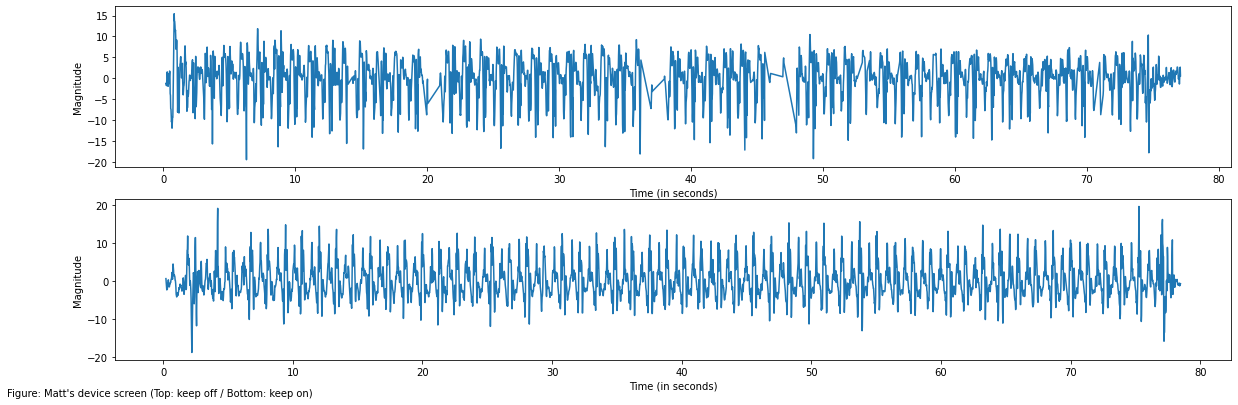

In [74]:
# Plotting Butterworth filtered data. Each line represents an axis.
fig, ax = plt.subplots(2)


# screen off plot
ax[0].set(xlabel='Time (in seconds)')
ax[0].set(ylabel='Magnitude')
ax[0].plot(screen_off['seconds'], screen_off['x'] +
         screen_off['y']+screen_off['z'])

# screen on plot
ax[1].set(xlabel='Time (in seconds)')
ax[1].set(ylabel='Magnitude')
ax[1].plot(screen_on['seconds'], screen_on['x'] +
           screen_on['y']+screen_on['z'])

plt.figtext(
    0.05, 0.048, 'Figure: Matt\'s device screen (Top: keep off / Bottom: keep on)')


# Butterworth Filter
Butterworth Filter work on the the gps signal really well, we have two plots below.
And we use Diego's data for demonstration. We can see the signal is much less noisy.

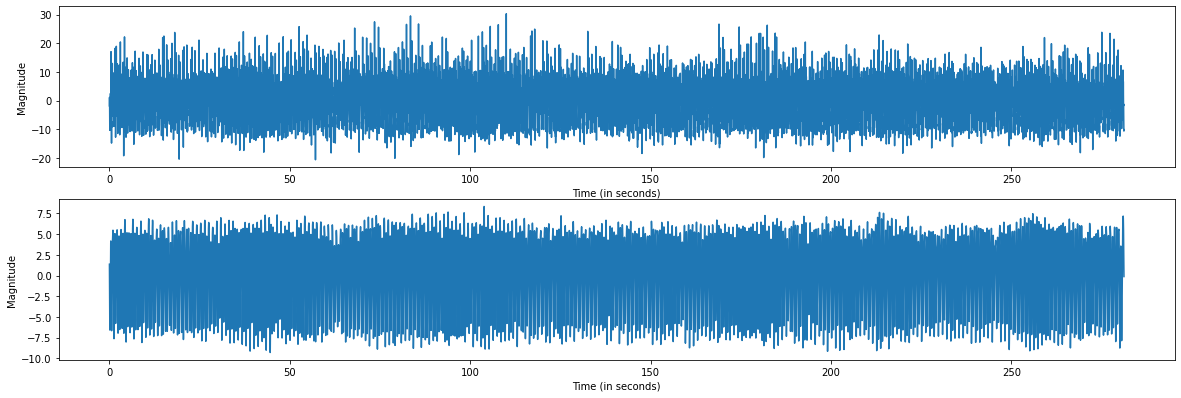

In [77]:
# Plotting Butterworth filtered data. Each line represents an axis.
fig, ax = plt.subplots(2)

# Diego raw data
ax[0].set(xlabel='Time (in seconds)')
ax[0].set(ylabel='Magnitude')
ax[0].plot(drp_5min['seconds'], drp_5min['x'] +
           drp_5min['y']+drp_5min['z'])

# Diego filtered data
ax[1].set(xlabel='Time (in seconds)')
ax[1].set(ylabel='Magnitude')
ax[1].plot(drp_5min_bw['seconds'], drp_5min_bw['x'] +
           drp_5min_bw['y']+drp_5min_bw['z'])



# Fourier Transform

We find that the higher guy has the lower frequency, maybe because tall guy with longer legs and it makes every step longer.

However, we don't believe we have enough height data, we just make an assumption of it.

(0.0, 1.0)

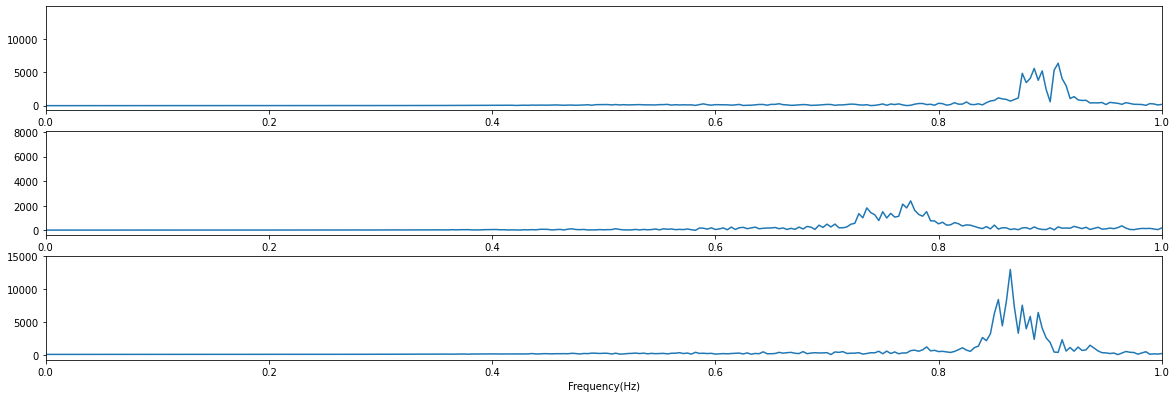

In [70]:
# Plotting Fourier transformed data. Each line represents a collection point (left pocket vs. right pocket).
fig, ax = plt.subplots(3)

# Diego (height: 5'8)
ax[0].set(xlabel='Frequency(Hz)')
ax[0].plot(drp5m_bw_fft['x'], drp5m_bw_fft['y'])
ax[0].set_xlim(0, 1)

# Matt (height: 6'0)
ax[1].set(xlabel='Frequency(Hz)') 
ax[1].plot(mrp5m_bw_fft['x'], mrp5m_bw_fft['y'])
ax[1].set_xlim(0, 1)

# Sidak (height: 5'10)
ax[2].set(xlabel='Frequency(Hz)')
ax[2].plot(srp5m_bw_fft['x'], srp5m_bw_fft['y'])
ax[2].set_xlim(0, 1)
